In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from skimage import transform

In [2]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Данные:
Будем работать с датасетом [Boston Housing Prices](https://medium.com/@haydar_ai/learning-data-science-day-9-linear-regression-on-boston-housing-dataset-cd62a80775ef).

Text(0.5,0,'Price')

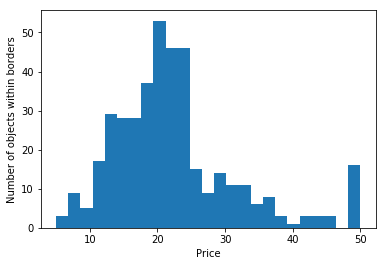

In [3]:
plt.hist(y_train, bins=25)
plt.ylabel('Number of objects within borders')
plt.xlabel('Price')

### Задание.
Будем решать задачу регрессии. Целевая переменная -- цена дома, признаки - различная информация о домохозяйстве. Для решения будем использовать линейную регрессию. Ваша задача - оценить качество решения в зависимости от количества объектов в обучающей выборке. Качество решения будем оценивать с помощью среднеквадратичной и среднеабсолютной ошибки, а так же [коэффициента детерминации $r^2$](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination). Также требуется оценить дисперсию данных функционалов в зависимости от числа объектов в обучающей выборке. 

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.externals.joblib import Parallel, delayed
from multiprocessing import Pool

Text(0.5,1,'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

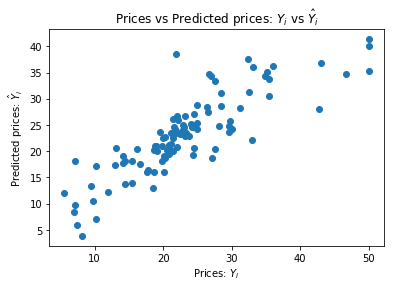

In [5]:
lm = LinearRegression()
lm.fit(x_train, y_train)

y_pred = lm.predict(x_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [6]:
print('mae = {}'.format(mean_absolute_error(y_test, y_pred)))
print('mse = {}'.format(mean_squared_error(y_test, y_pred)))
print('prediction variance = {}'.format(np.std((y_test - y_pred)**2)))

mae = 3.464185812406724
mse = 23.195599256422998
prediction variance = 45.78048685033721


In [7]:
def get_random_train_subsets(x_train, y_train, size):
    assert len(x_train) == len(y_train)
    # https://stackoverflow.com/questions/19485641/python-random-sample-of-two-arrays-but-matching-indices
    index = np.random.choice(np.arange(len(x_train)), size, replace=False)
    return (x_train[index], y_train[index])

def get_dict_from_list_of_tuples(lst):
    # https://stackoverflow.com/questions/28176949/convert-list-of-tuples-to-structured-numpy-array
    dt = np.dtype('float,float,float')
    dt.names = ['mae', 'mse', 'r2']
    return np.array(lst, dtype=dt)

In [8]:
class LinearRegressionTester:
    def __init__(self, x_train, y_train, x_test, y_test):
        assert len(x_train) == len(y_train)
        assert len(x_test) == len(y_test)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def test(self, size):
        assert size <= len(x_train)
        self.size = size
        test_results = self.run_tests()
        return get_dict_from_list_of_tuples(test_results)

    def run_tests(self):
        test_results = []
        for _ in range(self.get_num_of_tests()):
            test_result = self.test_linear_regression()
            test_results.append(test_result)
        return test_results

    def test_linear_regression(self):
        (x_train_subset, y_train_subset) = get_random_train_subsets(self.x_train, self.y_train, self.size)
        
        lm = LinearRegression()
        lm.fit(x_train_subset, y_train_subset)

        y_pred = lm.predict(self.x_test)

        mae = mean_absolute_error(self.y_test, y_pred)
        mse = mean_squared_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        return (mae, mse, r2)

    def get_num_of_tests(self):
        return 20

In [9]:
def plot_test_results(test_results):
    plt.plot(test_results['mae'])
    plt.plot(test_results['mse'])
    plt.plot(test_results['r2'])

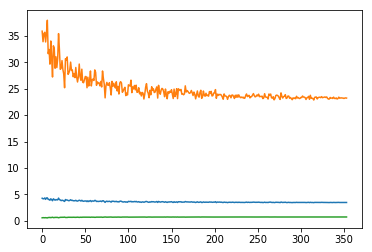

In [10]:
test_results = []
tester = LinearRegressionTester(x_train, y_train, x_test, y_test)

for size in range(50, len(x_train)):
    test_result = tester.test(size)
    
    mean_mae = np.mean(test_result['mae'])
    mean_mse = np.mean(test_result['mse'])
    mean_r2 = np.mean(test_result['r2'])
    
    test_results.append((mean_mae, mean_mse, mean_r2))
    
test_results = get_dict_from_list_of_tuples(test_results)
plot_test_results(test_results)

In [11]:
# # Plot code example from ODS Open Machine Course notebook from lesson 9
# # Source: https://github.com/Yorko/mlcourse_open/blob/master/jupyter_russian/topic09_time_series/topic9_part1_time_series_python.ipynb
#     plt.figure(figsize=(15, 5))
#     plt.plot(prediction_test, label="prediction")
#     plt.plot(lower, "r--", label="upper bond / lower bond")
#     plt.plot(upper, "r--")
#     plt.plot(list(y_test), label="y_test")
#     plt.plot(Anomalies, "ro", markersize=10)
#     plt.legend(loc="best")
#     plt.axis('tight')
#     plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
#     plt.grid(True)
#     plt.legend()

In [12]:
### Your code here